In [38]:
import json
import os
from collections import Counter
from itertools import combinations
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from scipy.sparse import hstack
from collections import defaultdict
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [3]:
data = json.load(open('train.json'))

In [5]:
len(data.keys())

64

In [6]:
data.keys()

dict_keys(['P931', 'P4552', 'P140', 'P1923', 'P150', 'P6', 'P27', 'P449', 'P1435', 'P175', 'P1344', 'P39', 'P527', 'P740', 'P706', 'P84', 'P495', 'P123', 'P57', 'P22', 'P178', 'P241', 'P403', 'P1411', 'P135', 'P991', 'P156', 'P176', 'P31', 'P1877', 'P102', 'P1408', 'P159', 'P3373', 'P1303', 'P17', 'P106', 'P551', 'P937', 'P355', 'P710', 'P137', 'P674', 'P466', 'P136', 'P306', 'P127', 'P400', 'P974', 'P1346', 'P460', 'P86', 'P118', 'P264', 'P750', 'P58', 'P3450', 'P105', 'P276', 'P101', 'P407', 'P1001', 'P800', 'P131'])

In [9]:
c = Counter([len(data[k]) for k in data])

In [10]:
c

Counter({700: 64})

In [11]:
data['P127'][0]

{'tokens': ['Amityville',
  'is',
  'the',
  'westernmost',
  'station',
  'on',
  'the',
  'Babylon',
  'Branch',
  'of',
  'the',
  'Long',
  'Island',
  'Rail',
  'Road',
  'in',
  'Suffolk',
  'County',
  ',',
  'New',
  'York',
  '.'],
 'h': ['babylon branch', 'Q4838506', [[7, 8]]],
 't': ['long island rail road', 'Q125943', [[11, 12, 13, 14]]]}

In [12]:
# тут будем держать сущности
ent1 = []
ent2 = []

# тут будем хранить контексты
left = []
right = []
middle = []

# целые предложения тоже на всякий случай достанем
sents = []

# целевая переменная (тип отношений будет тут)
target = []


# проходим по типам отношений
for key in data:
    # по каждому инстансу
    for instance in data[key]:
        
        tokens = instance['tokens']
        sents.append(tokens)
        
        ent1.append(' '.join([tokens[i] for i in instance['h'][2][0]]))
        ent2.append(' '.join([tokens[i] for i in instance['t'][2][0]]))
        
        
        # h и t не обязательно идут в таком порядке
        # чтобы достать контексты нужно понять что из них идет первым
        if instance['h'][2][0][0] < instance['t'][2][0][0]:
            first, second = 'h', 't'
        else:
            second, first = 'h', 't'
        
        
        # индексы сущностей
        first_start = instance[first][2][0][0]
        first_end = instance[first][2][0][-1]
        second_start = instance[second][2][0][0]
        second_end = instance[second][2][0][-1]

        # левый контекст - это три слова слева от начала первой сущности
        # если слева меньше 3 слов, то добавим тэгов <START>
        left_context = tokens[max(0, first_start-3):first_start]
        left.append((['<START>']*(3-len(left_context))) + left_context)
        
        # правый контекст - это 3 слова после последнего слова второй сущности
        # если справа меньше 3 слов, то добавим тэгов <END>
        right_context = tokens[second_end+1:second_end+4]
        right.append(right_context + (['<END>']*(3-len(right_context))))

        # средний контекст - это слова между последний словом первой сущности 
        # и первым словом второй сущности
        middle_context = tokens[first_end+1:second_start]
        middle.append(middle_context)

        target.append(key)

In [47]:
lefts_s = [' '.join(l) for l in left]
rights_s = [' '.join(l) for l in right]
middles_s = [' '.join(l) for l in middle]

#tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
#tfidf.fit(lefts_s + rights_s + middles_s)

#l = tfidf.fit_transform(lefts_s)
#r = tfidf.fit_transform(rights_s)
#m = tfidf.fit_transform(middles_s)

#X = csr_matrix(hstack([l,m,r])) # чтобы можно было по индексам доставать

### Векторизируем контексты при помощи word2vec

Для обучения возьмем эмбеддинги Wikipedia dependency (отсюда https://github.com/3Top/word2vec-api#where-to-get-a-pretrained-models)

In [27]:
from gensim.models import KeyedVectors
from tqdm import tqdm_notebook

In [24]:
model=KeyedVectors.load_word2vec_format('wiki.en.vec')

Пишем функцию, которая посчитает нам эмбединги для контекстов, представляя их в виде матрицы

In [51]:
def count_embeddings(cont):
    
    embed = np.zeros((len(cont),300))
    for i in tqdm_notebook(range(len(cont))):
        summ = 0
        words = cont[i].split()
        for word in words:
            if len(words)!=0:
                embed[i,:]=summ/len(words)
    return np.array(embed)

In [52]:
lefts_s = count_embeddings(lefts_s)
rights_s = count_embeddings(rights_s)
middles_s = count_embeddings(middles_s)

In [30]:
X = np.hstack([lefts_s,middles_s,rights_s])

In [31]:
X.shape

(44800, 900)

In [32]:
y = np.array(target)

In [33]:
N = 4
skf = StratifiedKFold(n_splits=N, shuffle=True)
metrics_macro = np.zeros((3))
metrics_micro = np.zeros((3))
conf = np.zeros((len(set(y)), len(set(y))))

for train_index, test_index in skf.split(X, y):
    # Можно конечно что-нибудь посложнее, но для примера хватит и логрега
    clf = LogisticRegression()
    clf.fit(X[train_index], y[train_index])
    preds = clf.predict(X[test_index])
    
    metrics_macro += precision_recall_fscore_support(y[test_index], preds, average='macro')[:3]
    metrics_micro += precision_recall_fscore_support(y[test_index], preds, average='micro')[:3]
    
    conf += confusion_matrix(y[test_index], preds)

Для логистической регрессии результаты получились в районе 0.49. Я решила попробовать другие классификаторы, возможно, они позволили бы улучшить качество работы

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [43]:
N = 4
skf = StratifiedKFold(n_splits=N, shuffle=True)
metrics_macro = np.zeros((3))
metrics_micro = np.zeros((3))
conf = np.zeros((len(set(y)), len(set(y))))

for train_index, test_index in skf.split(X, y):
    clf = KNeighborsClassifier()
    clf.fit(X[train_index], y[train_index])
    preds = clf.predict(X[test_index])
    
    metrics_macro += precision_recall_fscore_support(y[test_index], preds, average='macro')[:3]
    metrics_micro += precision_recall_fscore_support(y[test_index], preds, average='micro')[:3]
    
    conf += confusion_matrix(y[test_index], preds)

In [45]:
print(metrics_micro/N)
print(metrics_macro/N)

[0.36272321 0.36272321 0.36272321]
[0.38673891 0.36272321 0.357345  ]


In [44]:
#для случайного леса метрики составили
#[0.32950893 0.32950893 0.32950893]
#[0.34133495 0.32950893 0.3281875 

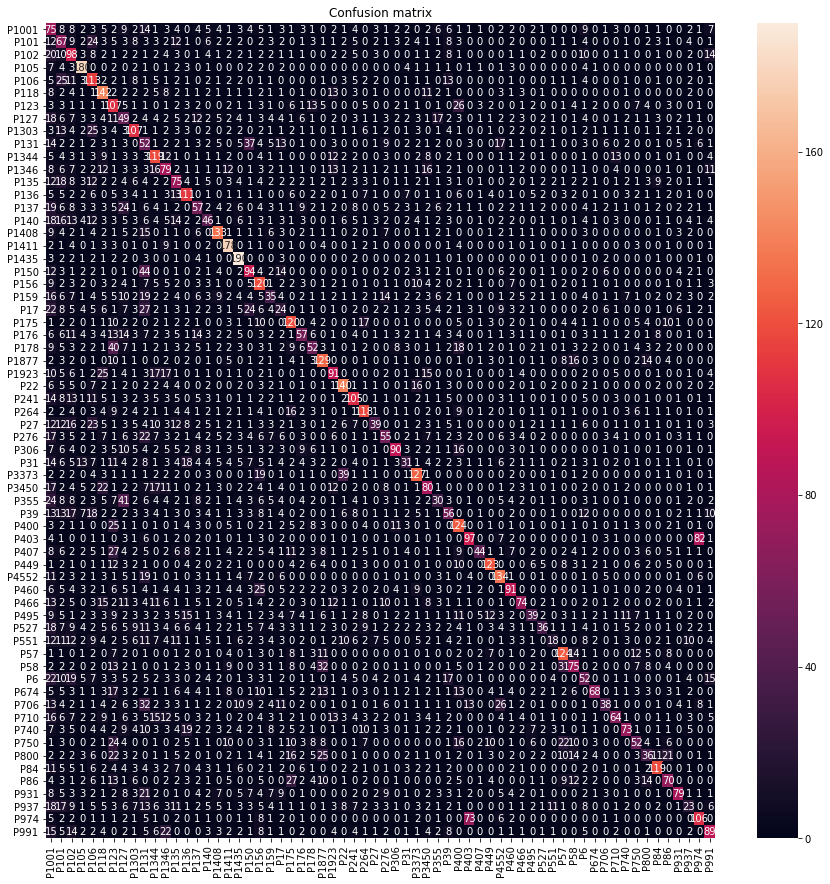

In [46]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=np.round(conf/3).astype(int), 
            annot=True, 
            fmt="d", xticklabels=clf.classes_, yticklabels=clf.classes_, ax=ax)
plt.title("Confusion matrix")
plt.show()

Чаще всего классификатор путает p403 и p974 (82 раза), и p150 c p131. Посмотрим, что это за классы.

In [59]:
data['P403'][0]

{'tokens': ['The',
  'Peel',
  'watershed',
  'drains',
  '14',
  '%',
  'of',
  'the',
  'Yukon',
  'Territory',
  'Canada',
  'and',
  'flows',
  'into',
  'the',
  'Beaufort',
  'Sea',
  'via',
  'the',
  'Peel',
  'and',
  'then',
  'Mackenzie',
  'Rivers',
  '.'],
 'h': ['mackenzie', 'Q3411', [[22]]],
 't': ['beaufort sea', 'Q131274', [[15, 16]]]}

In [55]:
data['P974'][0]

{'tokens': ['The',
  'east',
  'side',
  'of',
  'Grace',
  'Peak',
  'drains',
  'into',
  'Lindsay',
  'Brook',
  ',',
  'thence',
  'into',
  'the',
  'Schroon',
  'River',
  ',',
  'the',
  'Hudson',
  'River',
  ',',
  'and',
  'into',
  'New',
  'York',
  'Bay',
  '.'],
 'h': ['hudson river', 'Q3140', [[18, 19]]],
 't': ['schroon river', 'Q7432908', [[14, 15]]]}

В этом случае может играть роль частого упоминания локаций, рек и морей.

In [56]:
data['P150'][0]

{'tokens': ['The',
  'sailor',
  'was',
  'rescued',
  'by',
  'Saudi',
  'Arabian',
  'border',
  'guards',
  'in',
  'the',
  'Red',
  'Sea',
  'and',
  'taken',
  'to',
  'Jizan',
  'Province',
  'of',
  'Saudi',
  'Arabia',
  '.'],
 'h': ['saudi arabia', 'Q851', [[19, 20]]],
 't': ['jizan province', 'Q269973', [[16, 17]]]}

In [57]:
data['P131'][0]

{'tokens': ['Downing',
  'House',
  'is',
  'a',
  'historic',
  'home',
  'located',
  'at',
  'Memphis',
  ',',
  'Scotland',
  'County',
  ',',
  'Missouri',
  '.'],
 'h': ['memphis', 'Q962034', [[8]]],
 't': ['scotland county, missouri', 'Q496971', [[10, 11, 12, 13]]]}

In [60]:
Тут не очень понятно, возможно, тоже связано с указаниаем локаций.

SyntaxError: invalid syntax (<ipython-input-60-07eb7b40281f>, line 1)

### Задание 2

Я прочитала статью «[Open Information Extraction from the Web»](http://www.aaai.org/Papers/IJCAI/2007/IJCAI07-429.pdf), и решила узнать подробнее о следующих методах и алгоритмах, в ней упоминаемых.

**Kernel-based methods**

Более традиционно по-русски — «ядерные методы». Группа методов в машинном обучении, нацеленная на поиск и распознавание образов в массивах данных. От других алгоритмов распознавания образов отличаются тем, что в результате работы алгоритма данные не преобразуются в вектора признаков при помощи специальной схемы распределения признаков, — для этого достаточно только функции сходства пар точек данных, то есть ядра. При помощи таких ядерных функций алгоритмы могут работать в пространстве признаков высокой размерности за счет вычисления скалярных произведений между парами данных. То есть не нужно вычислять координаты всех данных в пространстве признаков. Основной метод из группы ядерных — метод опорных векторов. 

**Maximum-entropy** 

Принцип максимальной энтропии — согласно ему, наилучшим образом распределение вероятностей при неполноте информации может быть охарактеризовано за счет максимизации меры неопределенности. При работе с данными энтропия описывает сложность предсказаний событий по распределению вероятностей. Чем она больше, тем сложнее сделать правильные выводы. Основанные на этом принципе классификаторы максимизируют энтропию, чтобы в результате не получалось предсказание, подтверждений которому нет в обучающем корпусе.

**Noise tolerant learning algorithm**

Устойчивый к «шуму» алгоритм — данные часто оказываются загрязнены разного 
рода “шумами”, лишней информацией, которая мешает извлекать из них необходимое содержимое. Первые алгоритмы, которые должны были «отсекать лишнее», появились еще в середине 90-х — начале 2000-х годов, но с появлением big data они изучаются и сегодня. Разработка устойчивых к шуму алгоритмов тесно связана с вероятностно приближенным обучением (PAC — probably approximately correct learning).   
